# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from comp451.classifiers.neural_net import ThreeLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `ThreeLayerNet` in the file `comp451/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return ThreeLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `comp451/classifiers/neural_net.py` and look at the method `ThreeLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.03596154, -0.01613583, -0.00048556],
  [-0.09480192, 0.20724618, -0.09763798],
  [-0.07015667, 0.17081869, -0.07675745],
  [ 0.01473052, 0.09321097, -0.0395178 ],
  [-0.05306489, 0.04729807,  0.01750587]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.03596154 -0.01613583 -0.00048556]
 [-0.09480192  0.20724618 -0.09763798]
 [-0.07015667  0.17081869 -0.07675745]
 [ 0.01473052  0.09321097 -0.0395178 ]
 [-0.05306489  0.04729807  0.01750587]]

correct scores:
[[-0.03596154 -0.01613583 -0.00048556]
 [-0.09480192  0.20724618 -0.09763798]
 [-0.07015667  0.17081869 -0.07675745]
 [ 0.01473052  0.09321097 -0.0395178 ]
 [-0.05306489  0.04729807  0.01750587]]

Difference between your scores and correct scores:
4.807962381448306e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.1760667703015604

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, `b2`, `W3` and `b3`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from comp451.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, W3, b1, b2 and b3.
regp = 0.5

loss, grads = net.loss(X, y, reg=regp)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=regp)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.262252e-09
b1 max relative error: 7.670388e-09
W2 max relative error: 1.692191e-09
b2 max relative error: 4.590211e-10
W3 max relative error: 3.417401e-10
b3 max relative error: 8.037345e-11


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `ThreeLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `ThreeLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a three-layer network on toy data. You should achieve a training loss less than 0.21.

Final training loss:  0.20626818306089373


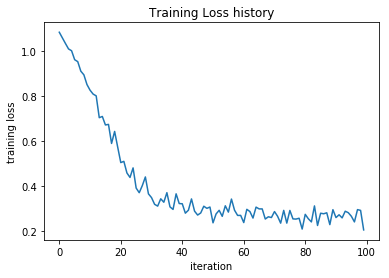

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a three-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [7]:
from comp451.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the three-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp451/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
np.random.seed(1)
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

net = ThreeLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-2, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.341590
iteration 100 / 1000: loss 2.317463
iteration 200 / 1000: loss 2.307715
iteration 300 / 1000: loss 2.304181
iteration 400 / 1000: loss 2.138494
iteration 500 / 1000: loss 2.124073
iteration 600 / 1000: loss 2.208880
iteration 700 / 1000: loss 2.154583
iteration 800 / 1000: loss 2.076965
iteration 900 / 1000: loss 2.014032
Validation accuracy:  0.307


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.307 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

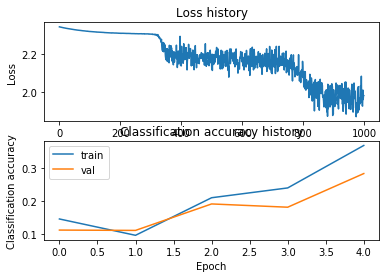

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

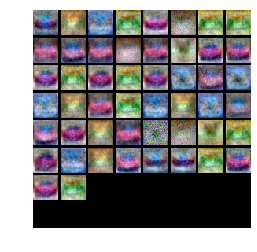

In [10]:
from comp451.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 50% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (50% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit Your Answer:}$

The process of generating random combinations is not effective. Such hyper parameters are best tuned by hand using one's experience and intuition. So I adjusted my hyperparameters by hand from my experience with deep learning.

1: the model seemed to learn better when I increse the number of iterations so I increased them gradually  till I reached 14000. 

2: Increasing the batch size didn't help and it was making things worse sometimes, so I chose 64. 

3: Increasing the learning rate made the model loss fluctuate and didn't decrease very well, si 0.001 was the best for me. 

4: Increasing the regularization strength was decreasing the accuracy, so I decreased it till I reached 0.02

5: Increasing the hidden size was making the model more complex and it overfitted. 50 was fine for me.

Then I put that hyperparameters combination along woth some other random combinations for the code to be like our previous classifiers. 

In [12]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


num_iters=14000
batch_size=64
learning_rate_decay=0.95
verbose=False
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

Combinations_reg_lr = [(0.02, 0.001), (0.2, 0.01), (0.1, 0.1)]

best_acc = 0.0
for reg, lr in Combinations_reg_lr:
    net = ThreeLayerNet(input_size, hidden_size, num_classes)
    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=num_iters, batch_size=batch_size,
                learning_rate=lr, learning_rate_decay=learning_rate_decay,
                reg=reg, verbose=verbose)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print('Validation accuracy: ', val_acc, "reg: ", reg, " lr: ", lr)
    if val_acc > best_acc: 
        best_acc = val_acc
        best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Validation accuracy:  0.496 reg:  0.02  lr:  0.001
Validation accuracy:  0.436 reg:  0.2  lr:  0.01
Validation accuracy:  0.119 reg:  0.1  lr:  0.1


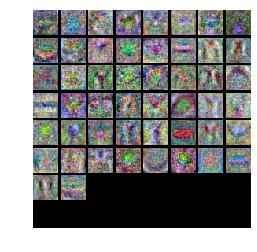

In [14]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [13]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.497


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ 1, and 3

$\color{blue}{\textit Your Explanation:}$

This problem is callled Overfitting. Here's the effect of each choice on it. 

1:- Training on larger dataset will prevent this overfitting. The model will be able to generalize well as long as these data is different than the already existing ones. 

2:- Adding more hidden units makes the model more comlex and it tends to overfit even more!

3:- Increasing regularization strench reduce the complexity of the model, and prevents this overfitting. 

